# Locally Linear Embedding (LLE) Analysis on Heart Disease Dataset

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

In [2]:
# Load the dataset
df_raw = pd.read_csv('data/heart.csv')
print(f"Original dataset shape: {df_raw.shape}")
df_raw.head()

Original dataset shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## 2. Data Preprocessing

### 2.1 Check for Missing Values

In [3]:
# Check missing values
print("Missing values per column:")
print(df_raw.isnull().sum())
print(f"\nTotal missing values: {df_raw.isnull().sum().sum()}")

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Total missing values: 0


### 2.2 Handle Duplicates

**Critical for LLE**: Duplicate rows cause singular weight matrices, leading to numerical errors. We must remove them.

In [4]:
# Check for duplicates
n_duplicates = df_raw.duplicated().sum()
print(f"Number of duplicate rows: {n_duplicates}")
print(f"Percentage of duplicates: {100 * n_duplicates / len(df_raw):.1f}%")

# Remove duplicates
df = df_raw.drop_duplicates().reset_index(drop=True)
print(f"\nDataset shape after removing duplicates: {df.shape}")

Number of duplicate rows: 723
Percentage of duplicates: 70.5%

Dataset shape after removing duplicates: (302, 14)


### 2.3 Basic Statistics

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


### Feature Description

| Feature | Description | Type |
|---------|-------------|------|
| age | Age in years | Continuous |
| sex | Sex (1=male, 0=female) | Binary |
| cp | Chest pain type (0-3) | Categorical |
| trestbps | Resting blood pressure (mm Hg) | Continuous |
| chol | Serum cholesterol (mg/dl) | Continuous |
| fbs | Fasting blood sugar > 120 mg/dl (1=true) | Binary |
| restecg | Resting ECG results (0-2) | Categorical |
| thalach | Maximum heart rate achieved | Continuous |
| exang | Exercise induced angina (1=yes) | Binary |
| oldpeak | ST depression induced by exercise | Continuous |
| slope | Slope of peak exercise ST segment | Categorical |
| ca | Number of major vessels colored by flourosopy (0-4) | Discrete |
| thal | Thalassemia (1=normal, 2=fixed defect, 3=reversible defect) | Categorical |
| target | Heart disease (1=yes, 0=no) | Binary |

### 2.4 Check for Outliers

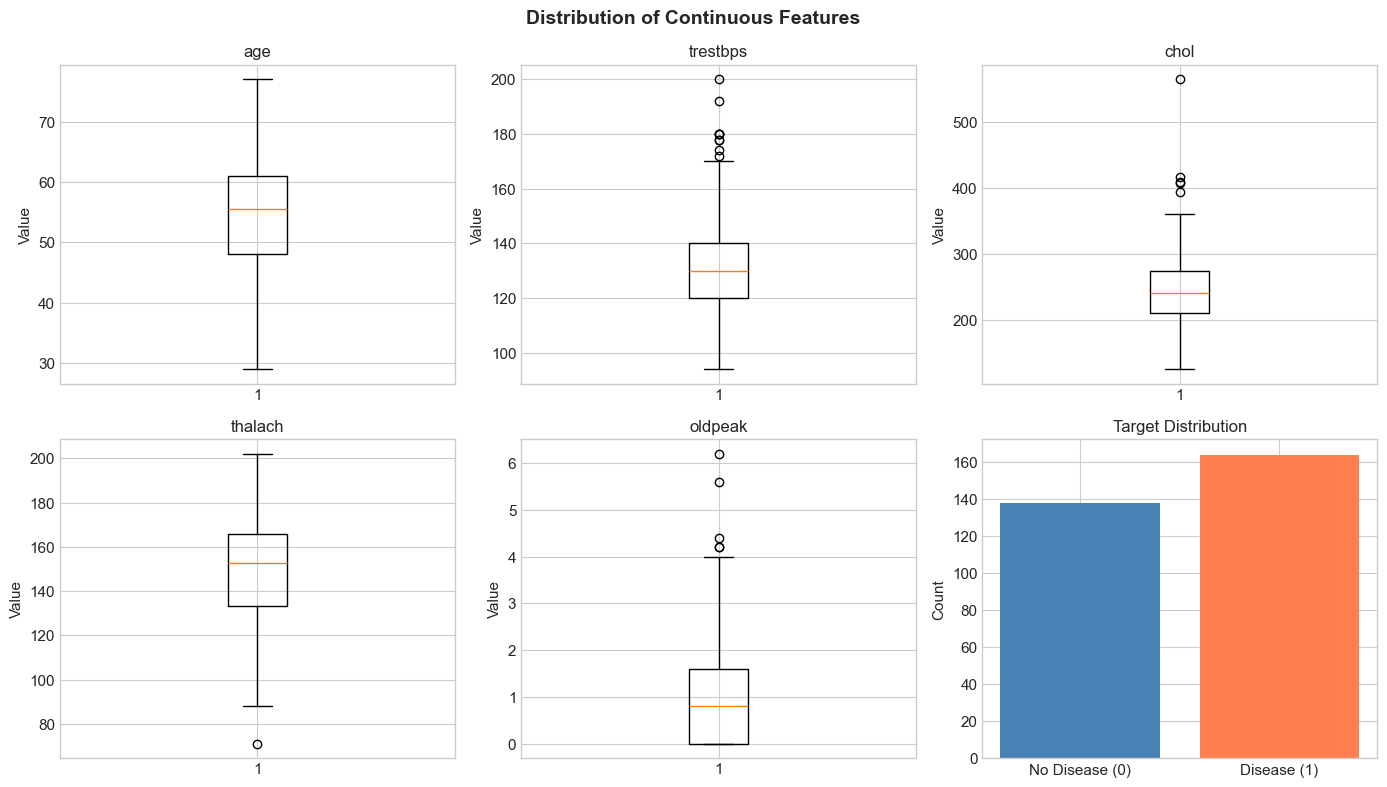

In [7]:
# Visualize distributions of continuous variables
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, col in enumerate(continuous_cols):
    axes[idx].boxplot(df[col], vert=True)
    axes[idx].set_title(f'{col}', fontsize=12)
    axes[idx].set_ylabel('Value')

# Target distribution
axes[5].bar(['No Disease (0)', 'Disease (1)'], df['target'].value_counts().sort_index(), 
            color=['steelblue', 'coral'])
axes[5].set_title('Target Distribution', fontsize=12)
axes[5].set_ylabel('Count')

plt.suptitle('Distribution of Continuous Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Variable Selection for LLE

For LLE, we select **continuous variables** that capture the physiological state of the heart. This makes the local linear approximation assumption more reasonable.

**Selected features:**
- `age`: Patient age
- `trestbps`: Resting blood pressure
- `chol`: Serum cholesterol
- `thalach`: Maximum heart rate achieved
- `oldpeak`: ST depression induced by exercise

In [8]:
# Select continuous features for LLE
selected_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

print("Selected features for LLE:")
for feat in selected_features:
    print(f"  - {feat}")

# Extract feature matrix and target
X = df[selected_features].values
y = df['target'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Class distribution: No Disease={sum(y==0)}, Disease={sum(y==1)}")

Selected features for LLE:
  - age
  - trestbps
  - chol
  - thalach
  - oldpeak

Feature matrix shape: (302, 5)
Class distribution: No Disease=138, Disease=164


### 3.1 Feature Scaling

Standardization is **essential** for LLE since it's a distance-based algorithm.

In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature statistics after scaling:")
scaled_df = pd.DataFrame(X_scaled, columns=selected_features)
scaled_df.describe().round(3)

Feature statistics after scaling:


,age,trestbps,chol,thalach,oldpeak
count,302.000,302.000,302.000,302.000,302.000
mean,-0.000,-0.000,-0.000,-0.000,-0.000
std,1.002,1.002,1.002,1.002,1.002
min,-2.814,-2.145,-2.332,-3.436,-0.900
25%,-0.711,-0.662,-0.687,-0.714,-0.900
50%,0.120,-0.091,-0.116,0.128,-0.210
75%,0.728,0.479,0.547,0.719,0.480
max,2.500,3.901,6.145,2.293,4.447


### 3.2 Correlation Analysis

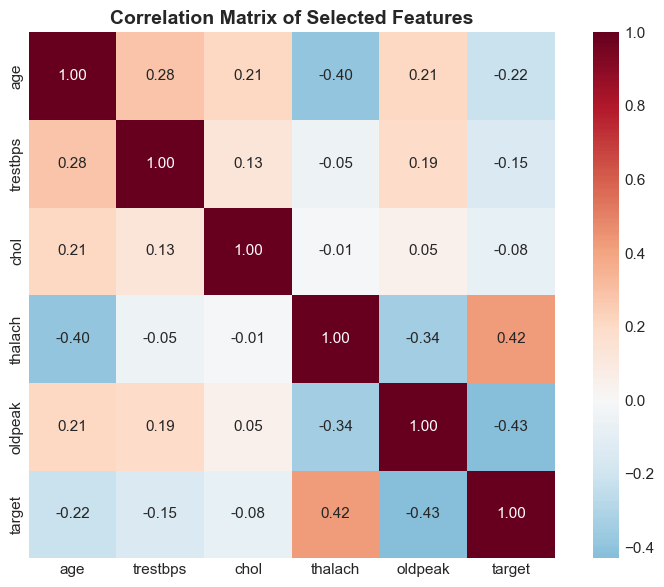

In [10]:
# Correlation heatmap of selected features
plt.figure(figsize=(8, 6))
corr_matrix = df[selected_features + ['target']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True)
plt.title('Correlation Matrix of Selected Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Choosing the Number of Neighbors (k)

The key hyperparameter in LLE is `n_neighbors` (k). Let's analyze the data structure to choose an appropriate value.

**Guidelines:**
- k should be > n_components (dimensions to reduce to)
- k should be small enough to capture local structure
- k should be large enough to avoid noise sensitivity

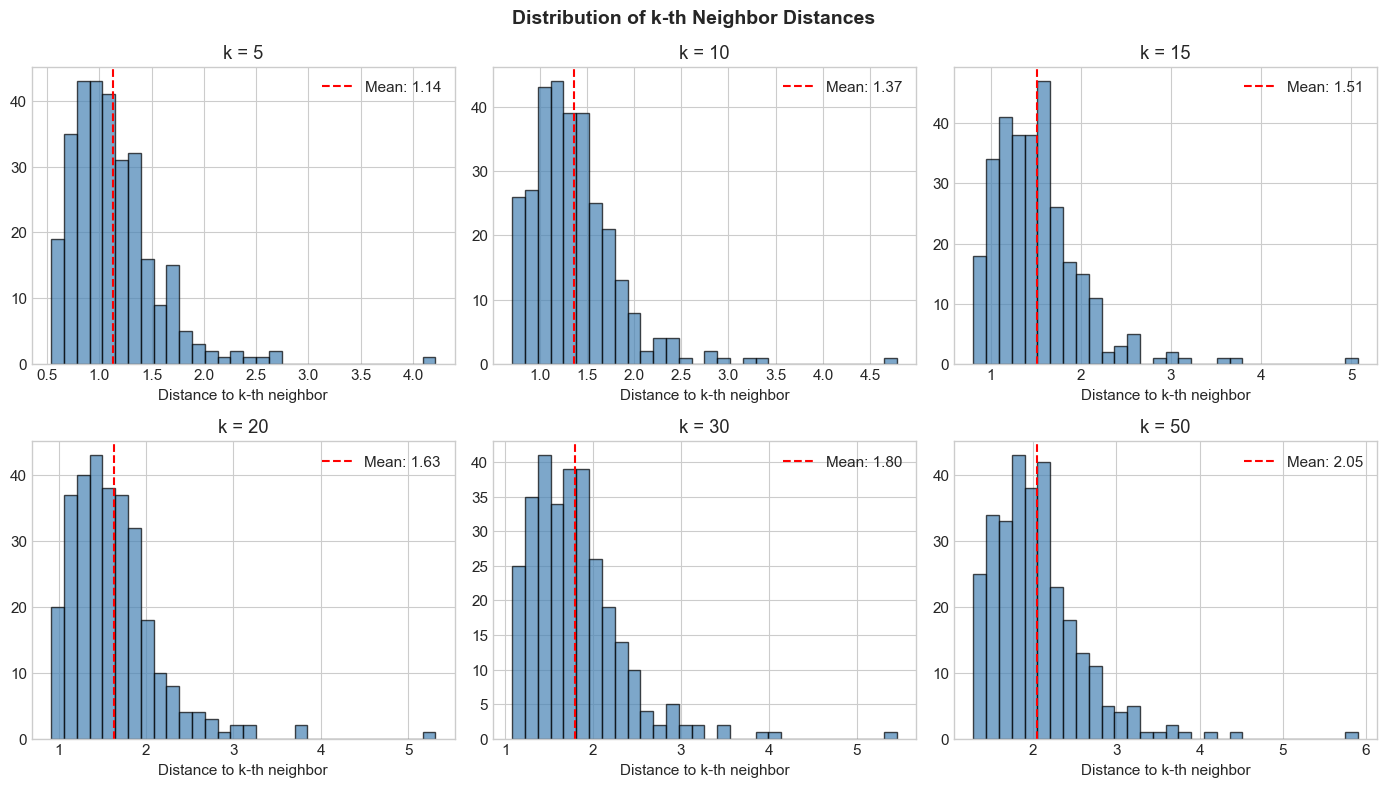

In [11]:
# Analyze k-nearest neighbor distances
k_values = [5, 10, 15, 20, 30, 50]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)
    mean_dist = distances[:, -1]  # Distance to k-th neighbor
    
    axes[idx].hist(mean_dist, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(np.mean(mean_dist), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(mean_dist):.2f}')
    axes[idx].set_title(f'k = {k}')
    axes[idx].set_xlabel('Distance to k-th neighbor')
    axes[idx].legend()

plt.suptitle('Distribution of k-th Neighbor Distances', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation**: We want k large enough to capture local structure but small enough to maintain locality. A value around **k=15-20** provides a good balance for this dataset.

## 5. Applying LLE

We use `eigen_solver='dense'` and add regularization (`reg=1e-3`) to handle potential numerical instabilities.

In [12]:
# Apply standard LLE with k=15
n_neighbors = 15

lle = LocallyLinearEmbedding(
    n_neighbors=n_neighbors,
    n_components=2,
    method='standard',
    eigen_solver='dense',  # More stable than 'arpack' for this data
    reg=1e-3,              # Regularization to prevent singular matrices
    random_state=42
)

X_lle = lle.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {X_lle.shape[1]}")
print(f"Reconstruction error: {lle.reconstruction_error_:.6f}")

Original dimensions: 5
Reduced dimensions: 2
Reconstruction error: 0.000002


## 6. Visualizations

### 6.1 LLE Embedding - Main View

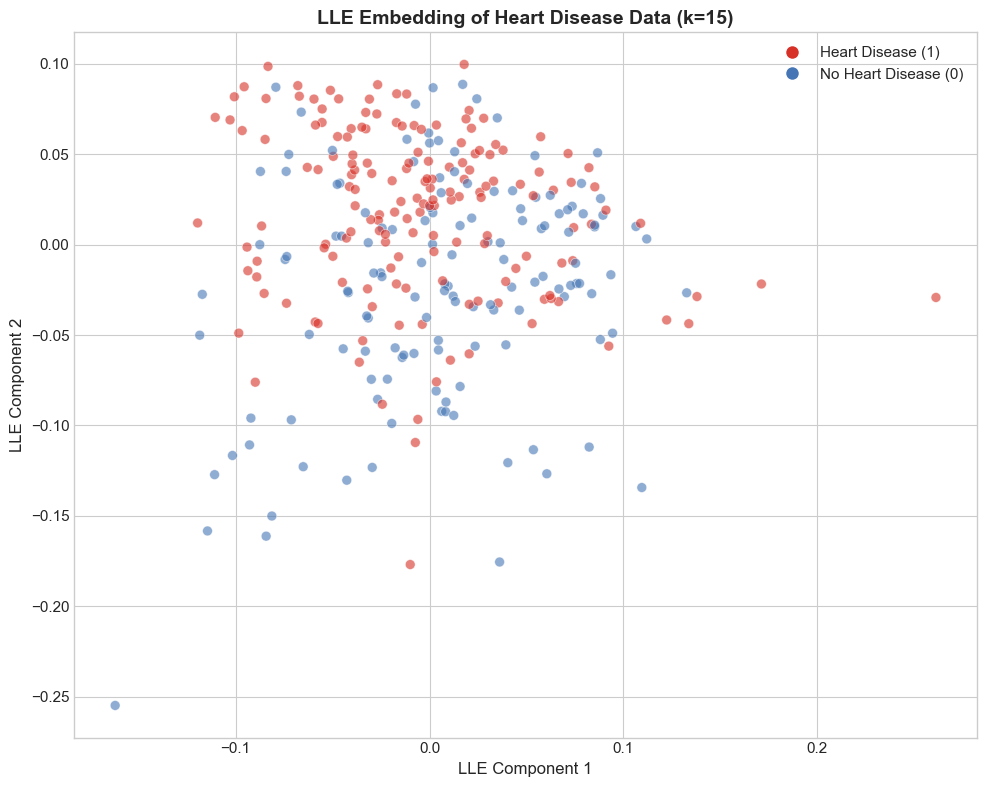

In [13]:
# Main LLE visualization colored by target
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#4575b4' if label == 0 else '#d73027' for label in y]

scatter = ax.scatter(
    X_lle[:, 0], X_lle[:, 1],
    c=colors,
    alpha=0.6,
    s=50,
    edgecolors='white',
    linewidth=0.5
)

ax.set_xlabel('LLE Component 1', fontsize=12)
ax.set_ylabel('LLE Component 2', fontsize=12)
ax.set_title(f'LLE Embedding of Heart Disease Data (k={n_neighbors})', fontsize=14, fontweight='bold')

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#d73027', markersize=10, label='Heart Disease (1)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#4575b4', markersize=10, label='No Heart Disease (0)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

### 6.2 Feature Overlay Analysis

Let's see how original features are distributed across the embedding.

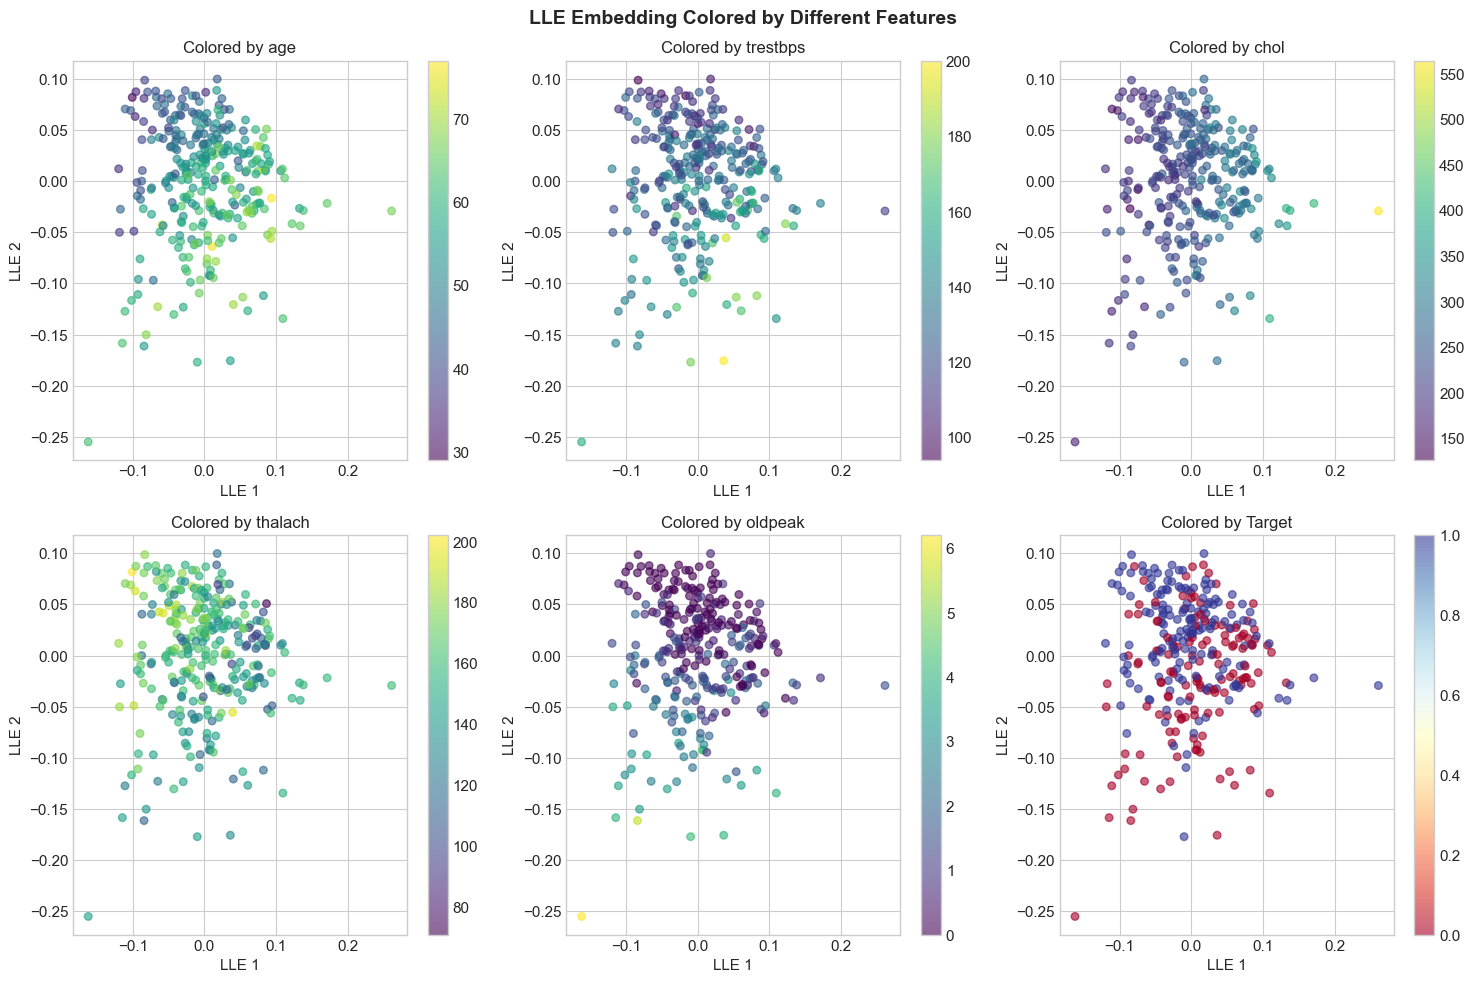

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feat in enumerate(selected_features):
    sc = axes[idx].scatter(
        X_lle[:, 0], X_lle[:, 1],
        c=df[feat].values,
        cmap='viridis',
        alpha=0.6,
        s=30
    )
    axes[idx].set_title(f'Colored by {feat}', fontsize=12)
    axes[idx].set_xlabel('LLE 1')
    axes[idx].set_ylabel('LLE 2')
    plt.colorbar(sc, ax=axes[idx])

# Last subplot: target
sc = axes[5].scatter(
    X_lle[:, 0], X_lle[:, 1],
    c=y,
    cmap='RdYlBu',
    alpha=0.6,
    s=30
)
axes[5].set_title('Colored by Target', fontsize=12)
axes[5].set_xlabel('LLE 1')
axes[5].set_ylabel('LLE 2')
plt.colorbar(sc, ax=axes[5])

plt.suptitle('LLE Embedding Colored by Different Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.3 Comparing Different k Values

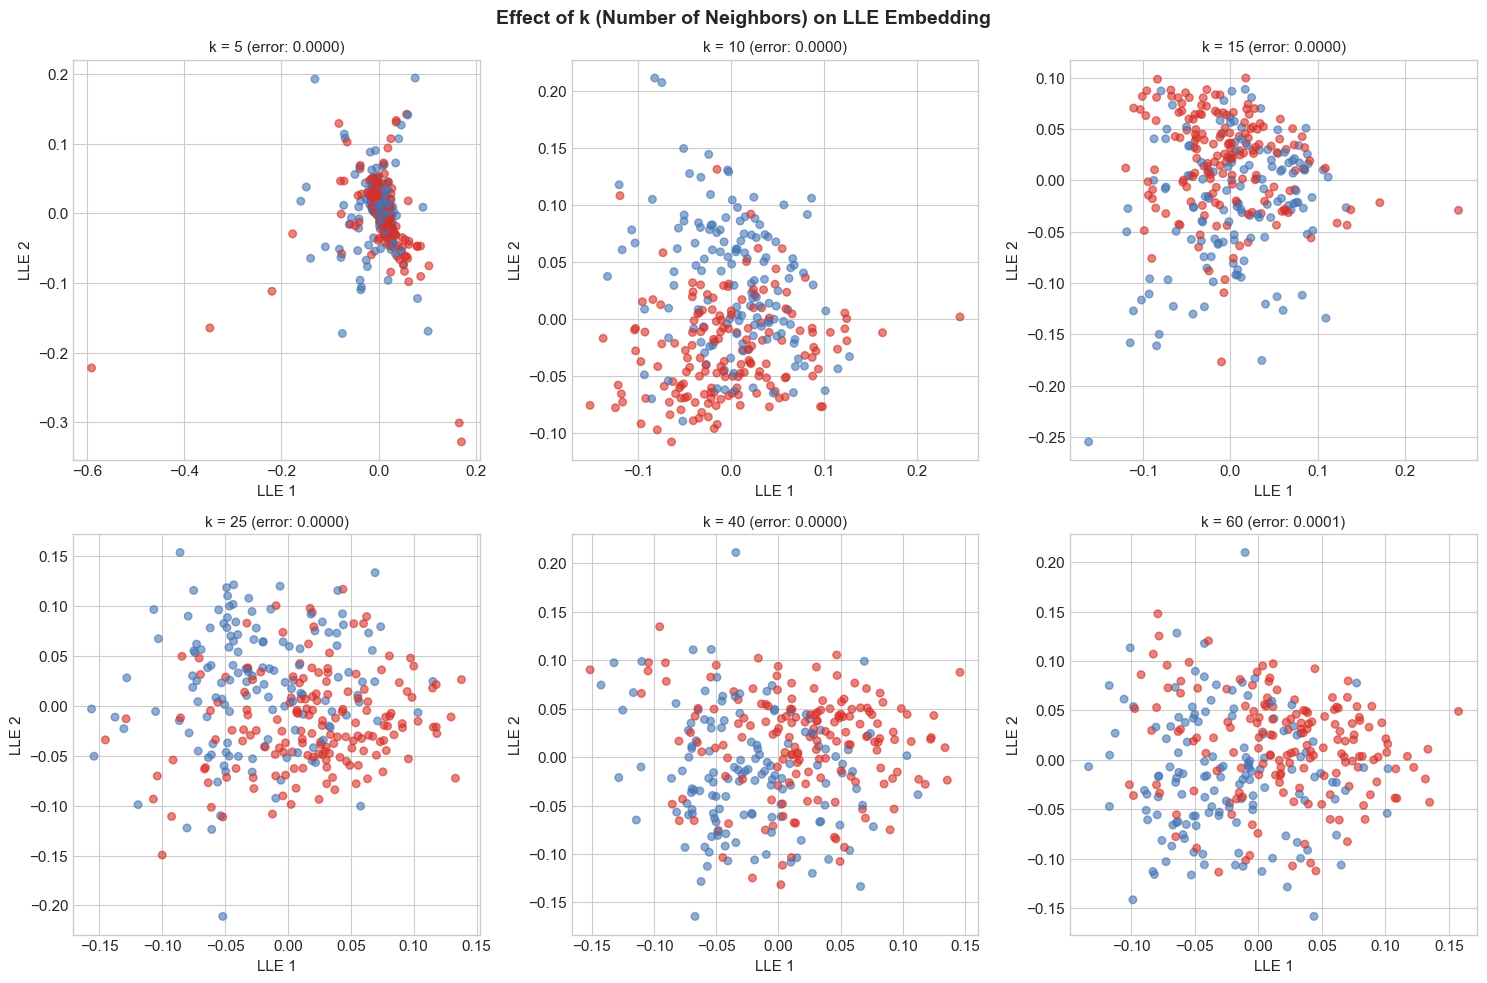

In [15]:
k_test = [5, 10, 15, 25, 40, 60]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, k in enumerate(k_test):
    lle_temp = LocallyLinearEmbedding(
        n_neighbors=k,
        n_components=2,
        method='standard',
        eigen_solver='dense',
        reg=1e-3,
        random_state=42
    )
    X_temp = lle_temp.fit_transform(X_scaled)
    
    colors = ['#4575b4' if label == 0 else '#d73027' for label in y]
    axes[idx].scatter(
        X_temp[:, 0], X_temp[:, 1],
        c=colors,
        alpha=0.6,
        s=30
    )
    axes[idx].set_title(f'k = {k} (error: {lle_temp.reconstruction_error_:.4f})', fontsize=11)
    axes[idx].set_xlabel('LLE 1')
    axes[idx].set_ylabel('LLE 2')

plt.suptitle('Effect of k (Number of Neighbors) on LLE Embedding', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.4 Comparing LLE Variants

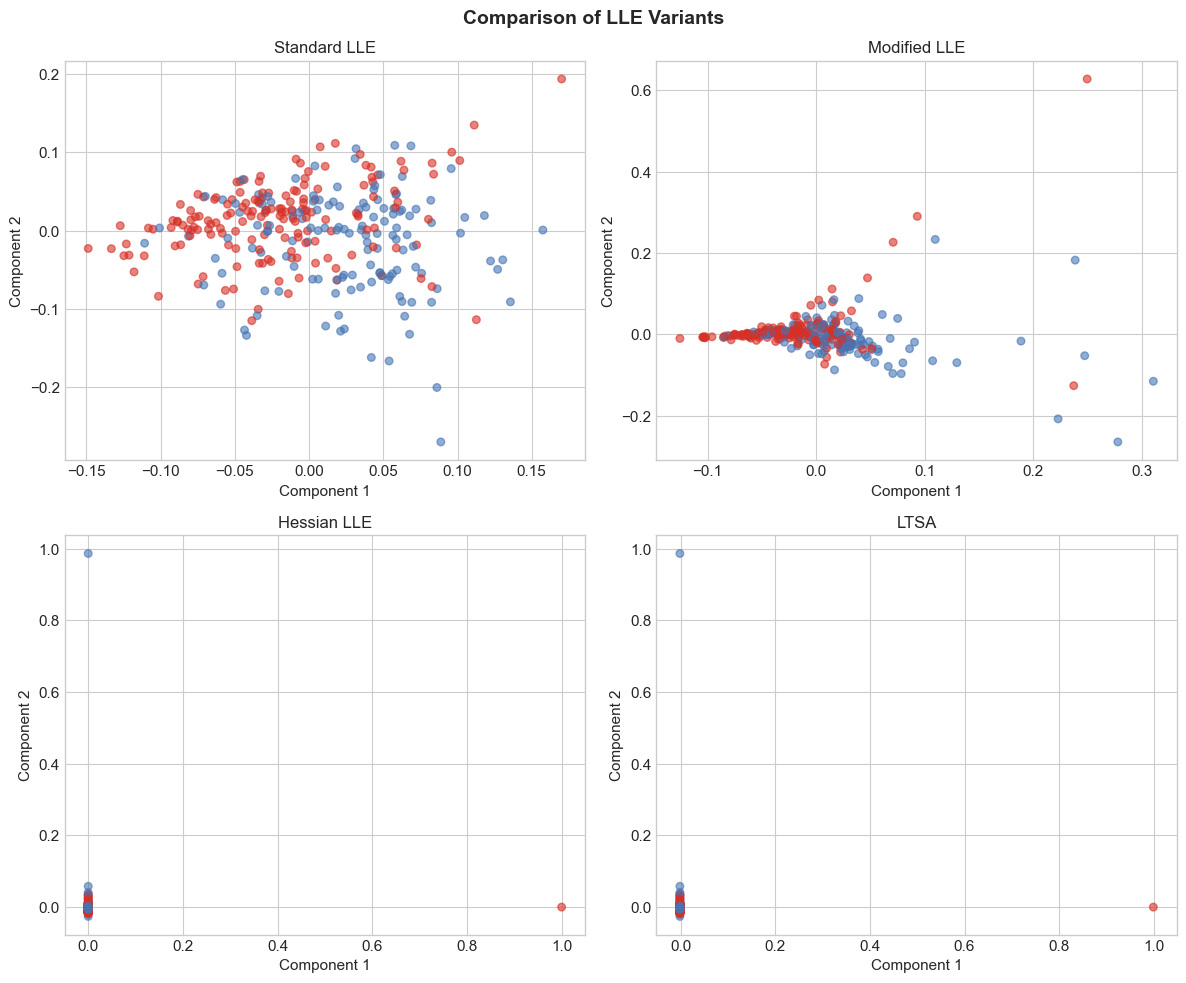

In [16]:
methods = ['standard', 'modified', 'hessian', 'ltsa']
method_names = ['Standard LLE', 'Modified LLE', 'Hessian LLE', 'LTSA']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Hessian and LTSA need n_neighbors > n_components * (n_components + 3) / 2
n_neighbors_variant = 20

for idx, (method, name) in enumerate(zip(methods, method_names)):
    try:
        lle_variant = LocallyLinearEmbedding(
            n_neighbors=n_neighbors_variant,
            n_components=2,
            method=method,
            eigen_solver='dense',
            reg=1e-3,
            random_state=42
        )
        X_variant = lle_variant.fit_transform(X_scaled)
        
        colors = ['#4575b4' if label == 0 else '#d73027' for label in y]
        axes[idx].scatter(
            X_variant[:, 0], X_variant[:, 1],
            c=colors,
            alpha=0.6,
            s=30
        )
        axes[idx].set_title(f'{name}', fontsize=12)
    except Exception as e:
        axes[idx].text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
                      transform=axes[idx].transAxes, ha='center')
        axes[idx].set_title(f'{name} (failed)', fontsize=12)
    
    axes[idx].set_xlabel('Component 1')
    axes[idx].set_ylabel('Component 2')

plt.suptitle('Comparison of LLE Variants', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.5 Class Separation Analysis

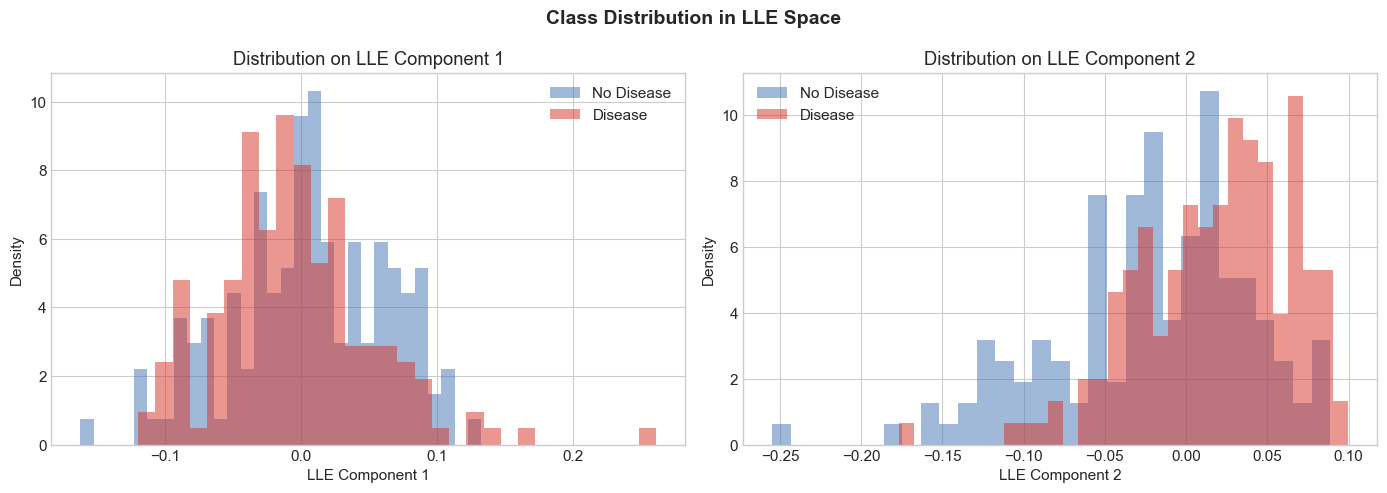

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Density plot for each class - Component 1
for label, name, color in [(0, 'No Disease', '#4575b4'), (1, 'Disease', '#d73027')]:
    mask = y == label
    axes[0].hist(X_lle[mask, 0], bins=30, alpha=0.5, label=name, color=color, density=True)
axes[0].set_xlabel('LLE Component 1')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution on LLE Component 1')
axes[0].legend()

# Density plot for each class - Component 2
for label, name, color in [(0, 'No Disease', '#4575b4'), (1, 'Disease', '#d73027')]:
    mask = y == label
    axes[1].hist(X_lle[mask, 1], bins=30, alpha=0.5, label=name, color=color, density=True)
axes[1].set_xlabel('LLE Component 2')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution on LLE Component 2')
axes[1].legend()

plt.suptitle('Class Distribution in LLE Space', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.6 2D Density Estimation

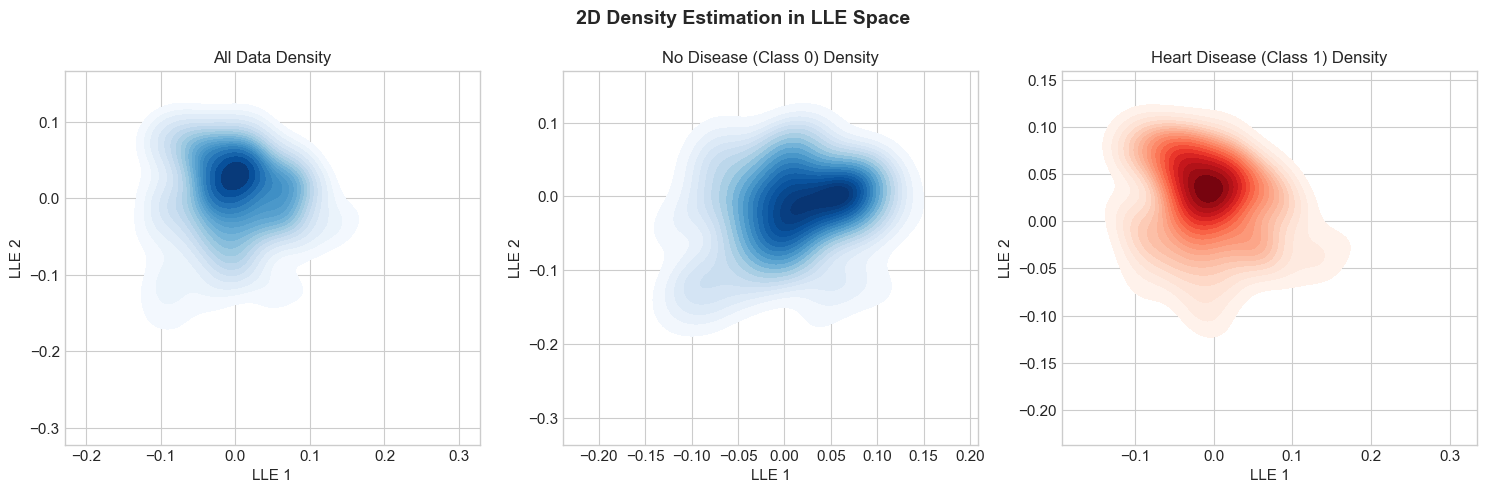

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# All data
sns.kdeplot(x=X_lle[:, 0], y=X_lle[:, 1], ax=axes[0], fill=True, cmap='Blues', levels=20)
axes[0].set_title('All Data Density', fontsize=12)
axes[0].set_xlabel('LLE 1')
axes[0].set_ylabel('LLE 2')

# No disease (class 0)
mask_0 = y == 0
sns.kdeplot(x=X_lle[mask_0, 0], y=X_lle[mask_0, 1], ax=axes[1], fill=True, cmap='Blues', levels=20)
axes[1].set_title('No Disease (Class 0) Density', fontsize=12)
axes[1].set_xlabel('LLE 1')
axes[1].set_ylabel('LLE 2')

# Disease (class 1)
mask_1 = y == 1
sns.kdeplot(x=X_lle[mask_1, 0], y=X_lle[mask_1, 1], ax=axes[2], fill=True, cmap='Reds', levels=20)
axes[2].set_title('Heart Disease (Class 1) Density', fontsize=12)
axes[2].set_xlabel('LLE 1')
axes[2].set_ylabel('LLE 2')

plt.suptitle('2D Density Estimation in LLE Space', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Reconstruction Error Analysis

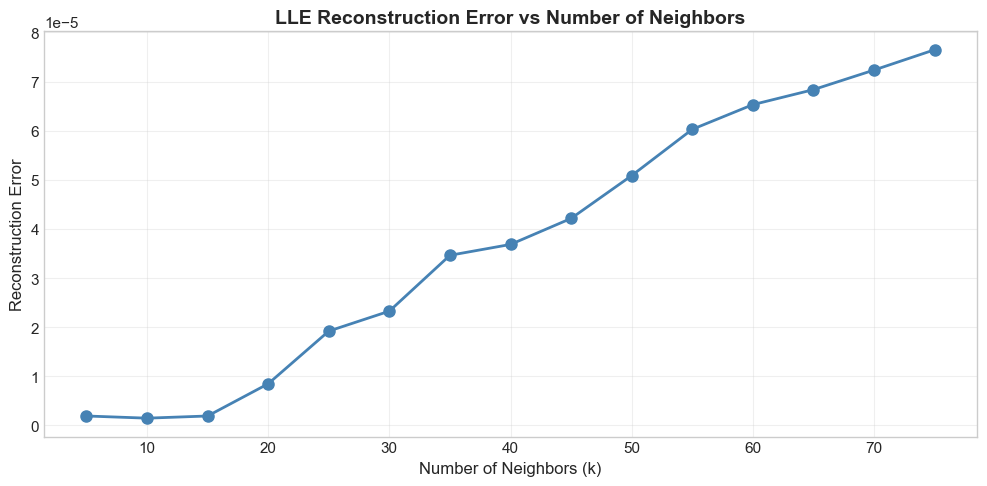

In [19]:
# Analyze reconstruction error vs number of neighbors
k_range = range(5, 80, 5)
errors = []

for k in k_range:
    lle_temp = LocallyLinearEmbedding(
        n_neighbors=k,
        n_components=2,
        method='standard',
        eigen_solver='dense',
        reg=1e-3,
        random_state=42
    )
    lle_temp.fit(X_scaled)
    errors.append(lle_temp.reconstruction_error_)

plt.figure(figsize=(10, 5))
plt.plot(list(k_range), errors, 'o-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Reconstruction Error', fontsize=12)
plt.title('LLE Reconstruction Error vs Number of Neighbors', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Summary Statistics

In [20]:
# Create summary dataframe with LLE coordinates
results_df = df.copy()
results_df['LLE_1'] = X_lle[:, 0]
results_df['LLE_2'] = X_lle[:, 1]

# Statistics by class
print("Mean LLE coordinates by class:")
print(results_df.groupby('target')[['LLE_1', 'LLE_2']].mean().round(4))
print("\nStandard deviation of LLE coordinates by class:")
print(results_df.groupby('target')[['LLE_1', 'LLE_2']].std().round(4))

Mean LLE coordinates by class:
        LLE_1   LLE_2
target               
0       0.006 -0.0221
1      -0.005  0.0186

Standard deviation of LLE coordinates by class:
         LLE_1   LLE_2
target                
0       0.0579  0.0616
1       0.0571  0.0467


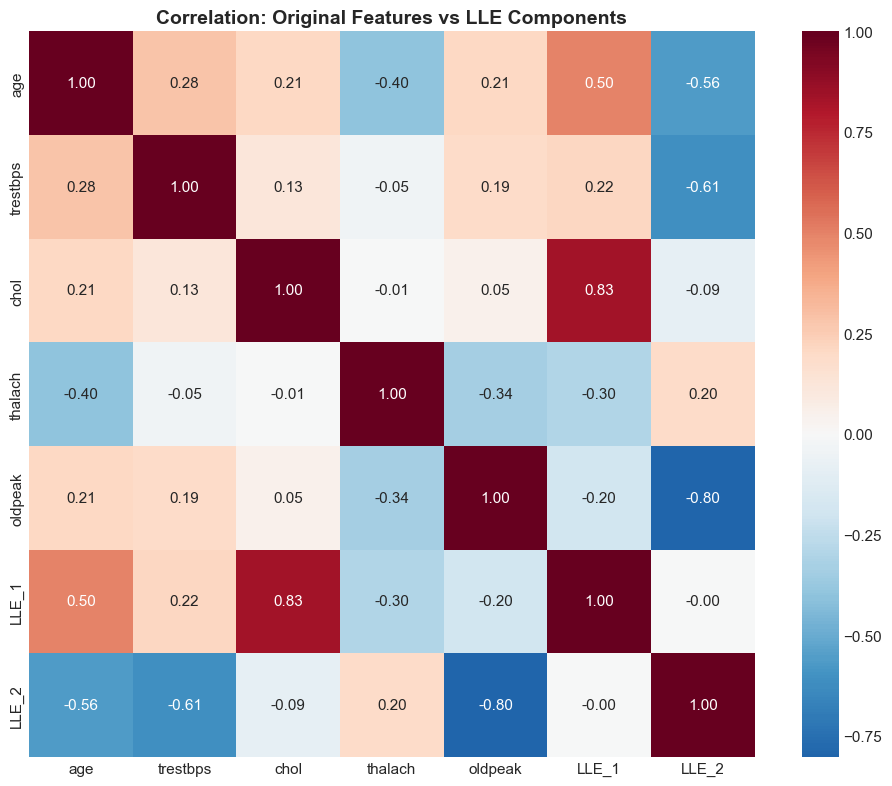

In [21]:
# Correlation between LLE components and original features
corr_matrix = results_df[selected_features + ['LLE_1', 'LLE_2']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True
)
plt.title('Correlation: Original Features vs LLE Components', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Interpretation and Key Findings

### What Does the LLE Embedding Tell Us?

**1. Manifold Structure**
- The heart disease data lies on a curved, nonlinear manifold in the original 5D space
- LLE successfully unrolls this manifold into 2D while preserving local neighborhoods
- Points that are close in the embedding share similar physiological characteristics

**2. Class Separation**
- The two classes (disease/no disease) show partial separation in LLE space
- Overlap regions suggest patients with ambiguous or borderline conditions
- This indicates the classification problem is non-trivial

**3. Feature Gradients**
- `thalach` (max heart rate) shows strong gradient along one direction
- `oldpeak` (ST depression) correlates with disease presence in the embedding
- Age distributes more uniformly, suggesting it interacts with other features

**4. Effect of k**
- Small k (5-10): Captures fine local structure but may be noisy
- Medium k (15-25): Good balance between local and global structure
- Large k (40+): Over-smoothed, loses local detail

### Clinical Interpretation

The LLE embedding reveals that patients form a continuous spectrum rather than two distinct groups. This aligns with the medical understanding that heart disease develops gradually, with many patients in transitional states.

## 10. Conclusion

This analysis demonstrates how LLE can reveal the intrinsic structure of medical data:

1. **Data Preprocessing is Critical**: Removing duplicates prevented singular matrix errors
2. **LLE preserves local relationships**: Patients with similar profiles remain clustered
3. **The embedding shows partial class separation**: Useful for understanding disease progression
4. **Feature importance** is visible through color gradients in the embedding
5. **Choosing k is crucial**: We found k=15-20 works well for this dataset

LLE is particularly valuable when you believe your data lies on a nonlinear manifold, which is common in biological/medical data where measurements are often correlated in complex, nonlinear ways.

### Technical Notes
- Used `eigen_solver='dense'` for numerical stability
- Added regularization (`reg=1e-3`) to handle near-singular weight matrices
- Removed duplicate rows from the original dataset to prevent singularity issues